In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML
import matplotlib.gridspec as gridspec
import panel as pn
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import matplotlib.ticker as ticker
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm


# file path
file_name = '/Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/data/organized_data/organized_data.csv'

In [2]:
df = pd.read_csv(file_name)

In [3]:
#filter out trials that do not start from 0

df['slider_values_rescaled'] = df['slider_values_rescaled'].apply(lambda x: [float(i) for i in x.split(',')])
# Convert from ms to seconds
df['slider_time_rescaled'] = df['slider_time'].apply(lambda x: [float(i) / 1000 for i in x.split(',')]) 

df['include'] = df['slider_values_rescaled'].apply(lambda x: x[0] == 0)

# Filter to include only trials that start from a slider value of 0
df['include'] = df['slider_values_rescaled'].apply(lambda x: x[0] == 0)
df_filtered = df[df['include']].copy()

# Determine the max length of the slider and time arrays from the filtered data
max_length_slider = df_filtered['slider_values_rescaled'].apply(len).max()
max_length_time = df_filtered['slider_time_rescaled'].apply(len).max()

# Pad the filtered arrays with NaNs to have the same length
df_filtered['slider_rescale_float_padded'] = df_filtered['slider_values_rescaled'].apply(
    lambda x: np.pad(x, (0, max_length_slider - len(x)), 'constant', constant_values=np.nan)
)
df_filtered['time_rescale_float_padded'] = df_filtered['slider_time_rescaled'].apply(
    lambda x: np.pad(x, (0, max_length_time - len(x)), 'constant', constant_values=np.nan)
)

# Function to calculate the average of the arrays
def average_values(x):
    # Stack the arrays, ignoring NaNs for the calculation of the mean
    return np.nanmean(np.stack(x), axis=0)

# Calculate the average for each participant at each speech rate for both sliders and time
df_avg = df_filtered.groupby(['participant', 'speech_rate']).agg({
    'slider_rescale_float_padded': average_values,
    'time_rescale_float_padded': average_values
}).reset_index()

# Rename columns
df_avg.rename(columns={
    'slider_rescale_float_padded': 'mean_slider_value',
    'time_rescale_float_padded': 'mean_time_value'
}, inplace=True)

# Now df_avg contains averages for filtered trials that start with a slider value of 0, including time values
print(df_avg)

    participant  speech_rate  \
0           p_1            1   
1           p_1            2   
2           p_1            3   
3           p_1            4   
4           p_1            5   
..          ...          ...   
105         p_9            1   
106         p_9            2   
107         p_9            3   
108         p_9            4   
109         p_9            5   

                                     mean_slider_value  \
0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
..                                                 ...   
105  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
106  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
107  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
108  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

/var/folders/s4/sw1k3wb56xl075rfw_q_80300000gr/T/ipykernel_25283/259284343.py:28: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.stack(x), axis=0)


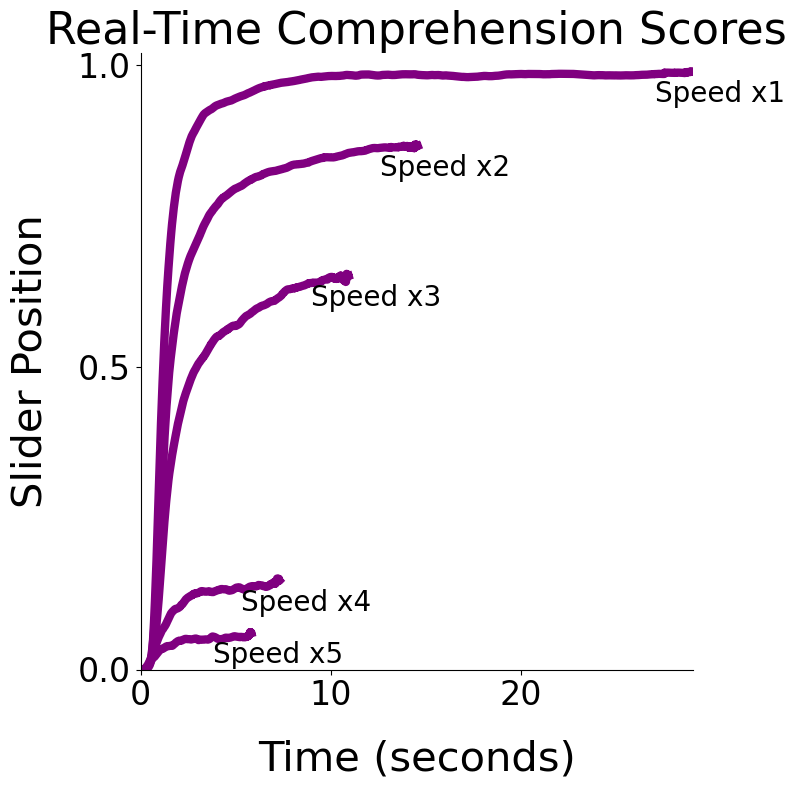

  participant  speech_rate                                         mean_times  \
0         p_1            1  [0.0039424, 0.007942399999999999, 0.0119424000...   
1        p_10            1  [0.003950909090909091, 0.007950909090909092, 0...   
2        p_11            1  [0.0039467999999999994, 0.0079468, 0.011946799...   
3        p_13            1  [0.003947600000000001, 0.0079476, 0.0119476000...   
4        p_14            1  [0.003933636363636364, 0.007933636363636367, 0...   

                                  mean_slider_values  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  


In [5]:
# line plot for real-time comprehension scores


# Initialize an empty list to store the aggregated data with participant information
aggregated_data = []

# Function to create a line plot of mean_slider_value over time and retain participant-level data
def create_line_plot(ax):
    speech_rates = sorted(df_filtered['speech_rate'].unique())

    # Plot mean_slider_value over time for each speech rate
    for speech_rate in speech_rates:
        # Filter data for the specific speech rate
        avg_data = df_avg[df_avg['speech_rate'] == speech_rate]
        mean_length = df_filtered.groupby('speech_rate')['slider_time_rescaled'].apply(lambda x: np.mean([len(times) for times in x]))[speech_rate]

        # Iterate over each participant to retain participant-level data
        for _, row in avg_data.iterrows():
            participant_id = row['participant']  
            mean_times = row['mean_time_value'][:int(mean_length)]
            mean_values = row['mean_slider_value'][:int(mean_length)]
            
            # Append participant-level data to the aggregated list
            aggregated_data.append({
                'participant': participant_id,
                'speech_rate': speech_rate,
                'mean_times': mean_times,
                'mean_slider_values': mean_values
            })
        
        # Compute group-level means for plotting
        group_mean_times = np.mean([row['mean_time_value'][:int(mean_length)] for _, row in avg_data.iterrows()], axis=0)
        group_mean_values = np.mean([row['mean_slider_value'][:int(mean_length)] for _, row in avg_data.iterrows()], axis=0)
        
        # Plot the mean values over time
        ax.plot(group_mean_times, group_mean_values, lw=6, color='purple', label=f'Speed x{speech_rate}')

        # Place the label slightly left of the rightmost part of each line
        ax.text(group_mean_times[-1] - 2, group_mean_values[-1] - 0.05, f'Speed x{speech_rate}', fontsize=20, color='black', ha='left')

    # Set axis labels and limits
    ax.set_ylabel("Slider Position", fontsize=30, labelpad=20)  
    ax.set_xlabel("Time (seconds)", fontsize=30, labelpad=20)
    ax.set_xlim(left=0, right=max(df_filtered.groupby('speech_rate')['slider_time_rescaled'].apply(lambda x: np.mean([len(times) for times in x]))) * 4 / 1000)
    ax.set_ylim(bottom=0, top=1.02)
    ax.set_yticks([0, 0.5, 1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=24)


# Create a new figure for the line plot with a square and smaller size
fig, ax = plt.subplots(figsize=(8, 8))  # Adjusted for a square plot

# Add the line plot
create_line_plot(ax)

# Set title
ax.set_title('Real-Time Comprehension Scores', fontsize=32)

# Show the plot
plt.tight_layout()
plt.show()

# Convert aggregated participant-level data to a DataFrame
df_means = pd.DataFrame(aggregated_data)

# Display the new df_means DataFrame to verify it contains participant-level data
print(df_means.head())



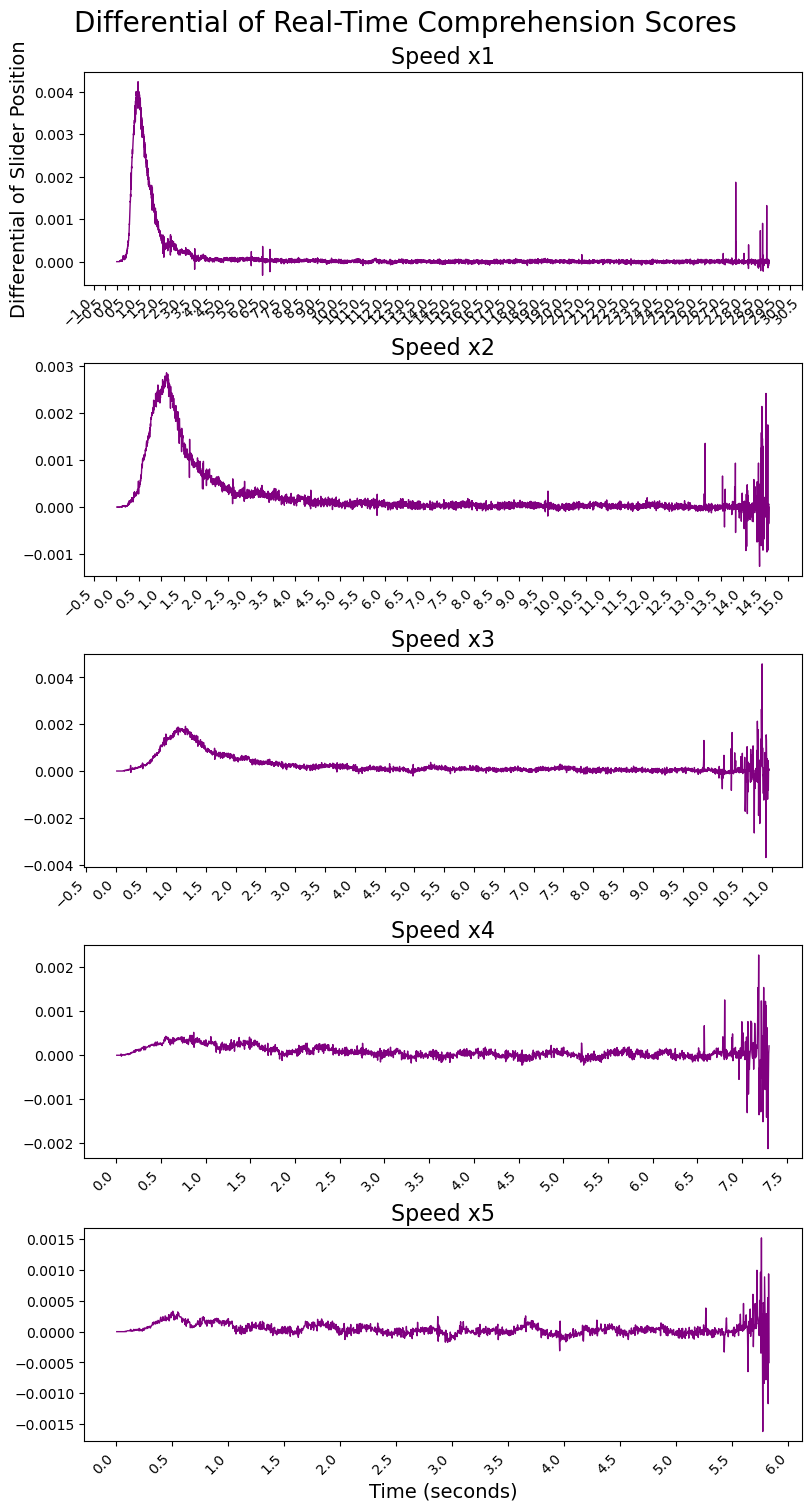

In [4]:
# Differentials

# Function to create a differential plot of mean_slider_value for a specific speech rate (without time normalization)
def create_differential_plot(ax, speech_rate):
    # Filter data for the specific speech rate
    avg_data = df_avg[df_avg['speech_rate'] == speech_rate]
    mean_length = df_filtered.groupby('speech_rate')['slider_time_rescaled'].apply(lambda x: np.mean([len(times) for times in x]))[speech_rate]
    
    # Extract numeric arrays for time and slider values
    mean_times = np.mean([row['mean_time_value'][:int(mean_length)] for _, row in avg_data.iterrows()], axis=0)
    mean_values = np.mean([row['mean_slider_value'][:int(mean_length)] for _, row in avg_data.iterrows()], axis=0)
    
    # Calculate the differential of mean_values without time normalization
    differential_values = np.diff(mean_values)
    
    # Plot the differential values
    ax.plot(mean_times[1:], differential_values, lw=1, color='purple')
    ax.set_title(f'Speed x{speech_rate}', fontsize=16)
    
    # Set x-axis ticks to show every 0.5 second
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
    
    # Rotate x-axis tick labels to be diagonal
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# List of speech rates
speech_rates = sorted(df_filtered['speech_rate'].unique())
num_speech_rates = len(speech_rates)

# Create a figure with subplots for each speech rate
fig, axes = plt.subplots(nrows=num_speech_rates, ncols=1, figsize=(8, 3 * num_speech_rates), constrained_layout=True)

# Plot each speech rate in its own subplot
for i, (ax, speech_rate) in enumerate(zip(axes, speech_rates)):
    create_differential_plot(ax, speech_rate)
    
    # Add x and y labels only on outer subplots
    if i == num_speech_rates - 1:  # Last row
        ax.set_xlabel("Time (seconds)", fontsize=14)
    if i == 0:  # First row
        ax.set_ylabel("Differential of Slider Position", fontsize=14)

# Set a main title for the figure
fig.suptitle('Differential of Real-Time Comprehension Scores', fontsize=20)

# Show the plot
plt.show()


cut-off points:

Speech Speed x1 : 4 s

SSx2: 2.5 s

SSx3: 2 s

SSx4: 1 s

SSx5: 0.5 s

In [6]:
# cut offs version 1: across participants, directly on means


# Average across participants for each speech rate
df_means_across_p = df_avg.groupby('speech_rate').agg(
    mean_times=('mean_time_value', lambda x: np.mean(np.vstack(x), axis=0)),
    mean_slider_values=('mean_slider_value', lambda x: np.mean(np.vstack(x), axis=0))
).reset_index()

# Create cutoffs for the aggregated data
cutoff_times = {1: 4, 2: 2.5, 3: 2, 4: 1, 5: 0.5}
cutoff_times_list = []
cutoff_values_list = []

for _, row in df_means_across_p.iterrows():
    speech_rate = row['speech_rate']
    mean_times = row['mean_times']
    mean_values = row['mean_slider_values']

    # Apply cutoffs
    cutoff_time_in_seconds = cutoff_times.get(speech_rate, None)
    if cutoff_time_in_seconds is not None:
        cutoff_index = np.searchsorted(mean_times, cutoff_time_in_seconds)
        cutoff_times_list.append(mean_times[cutoff_index:])
        cutoff_values_list.append(mean_values[cutoff_index:])

df_means_across_p['cutoff_mean_time'] = cutoff_times_list
df_means_across_p['cutoff_mean_slider_value'] = cutoff_values_list


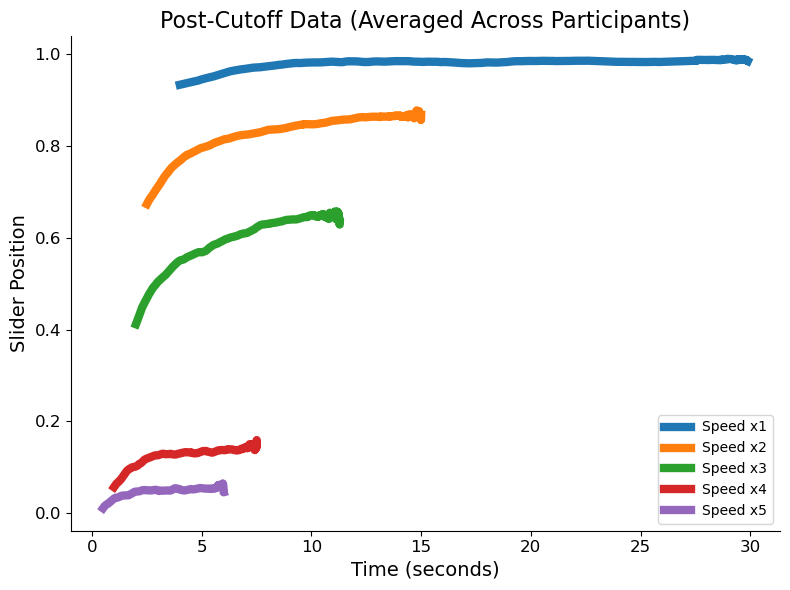

In [7]:
# plot verison1

# Plot the aggregated data
def plot_aggregated_data(df, ax, title):
    for _, row in df.iterrows():
        speech_rate = row['speech_rate']
        times = row['cutoff_mean_time']
        values = row['cutoff_mean_slider_value']
        ax.plot(times, values, label=f'Speed x{speech_rate}', lw=6)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Time (seconds)", fontsize=14)
    ax.set_ylabel("Slider Position", fontsize=14)
    ax.legend(fontsize=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', labelsize=12)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
plot_aggregated_data(df_means_across_p, ax, "Post-Cutoff Data (Averaged Across Participants)")
plt.tight_layout()
plt.show()

In [8]:
# version 2: apply the cut off points to each participant's data and the average across them

# Function to apply cutoffs to participant-level data in df_avg
def apply_cutoffs_to_participant_data(df, cutoff_times):
    cutoff_results = []

    for _, row in df.iterrows():
        speech_rate = row['speech_rate']
        mean_times = row['mean_time_value']
        mean_values = row['mean_slider_value']

        # Apply cutoffs
        cutoff_time_in_seconds = cutoff_times.get(speech_rate, None)
        if cutoff_time_in_seconds is not None:
            cutoff_index = np.searchsorted(mean_times, cutoff_time_in_seconds)
            post_cutoff_times = mean_times[cutoff_index:]
            post_cutoff_values = mean_values[cutoff_index:]
        else:
            post_cutoff_times = mean_times
            post_cutoff_values = mean_values

        cutoff_results.append({
            'speech_rate': speech_rate,
            'participant': row['participant'],  # Maintain participant info
            'cutoff_mean_time': post_cutoff_times,
            'cutoff_mean_slider_value': post_cutoff_values
        })

    return pd.DataFrame(cutoff_results)

# Apply cutoffs to participant-level data
df_means_with_participants = apply_cutoffs_to_participant_data(df_avg, cutoff_times)

# Aggregate the participant-level post-cutoff data for plotting
df_means_with_participants_aggregated = df_means_with_participants.groupby('speech_rate').agg(
    cutoff_mean_time=('cutoff_mean_time', lambda x: np.mean(np.vstack(x), axis=0)),
    cutoff_mean_slider_value=('cutoff_mean_slider_value', lambda x: np.mean(np.vstack(x), axis=0))
).reset_index()


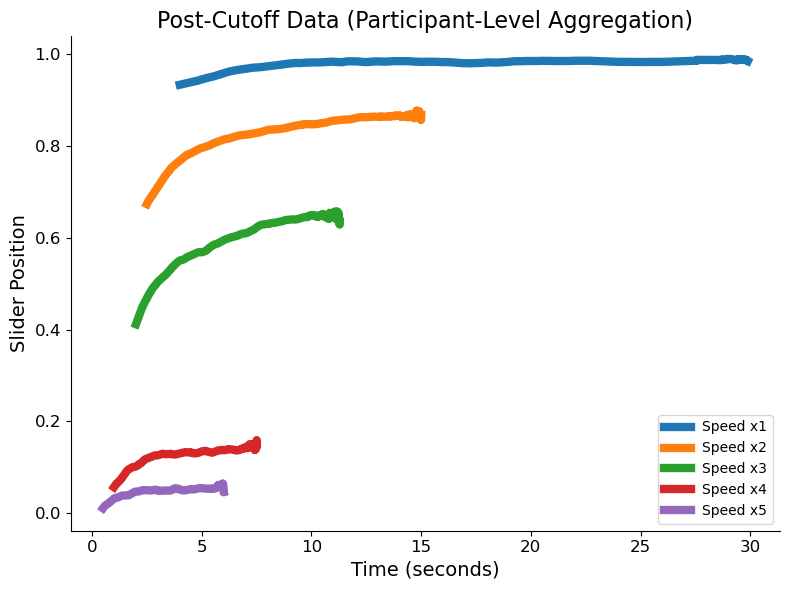

In [10]:
# plot version 2

def plot_aggregated_data(df, ax, title):
    for _, row in df.iterrows():
        speech_rate = row['speech_rate']
        times = row['cutoff_mean_time']  # Use correct column name
        values = row['cutoff_mean_slider_value']  # Use correct column name
        ax.plot(times, values, label=f'Speed x{speech_rate}', lw=6)
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Time (seconds)", fontsize=14)
    ax.set_ylabel("Slider Position", fontsize=14)
    ax.legend(fontsize=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', labelsize=12)


fig, ax = plt.subplots(figsize=(8, 6))
plot_aggregated_data(df_means_with_participants_aggregated, ax, "Post-Cutoff Data (Participant-Level Aggregation)")
plt.tight_layout()
plt.show()

In [9]:
# Remove nan values from cutoff_mean_slider_value for each participant and speech rate 
# the code that cutts it off padded the ends with nans
df_means_with_participants['cutoff_mean_slider_value'] = df_means_with_participants['cutoff_mean_slider_value'].apply(
    lambda x: [value for value in x if not np.isnan(value)]
)


In [10]:
# Initialize lists to store the binned values
bin1_list, bin2_list, bin3_list, bin4_list, bin5_list = [], [], [], [], []

# Loop over each row in df_means_with_participants
for _, row in df_means_with_participants.iterrows():
    # Extract slider values for the current participant and speech rate
    slider_values = np.array(row['cutoff_mean_slider_value'])
    
    # Remove NaNs from the slider values
    slider_values = slider_values[~np.isnan(slider_values)]
    
    if len(slider_values) > 0:
        # Calculate indices to evenly divide the array into 5 parts
        indices = np.linspace(0, len(slider_values), num=6, endpoint=True).astype(int)
        
        # Divide the values into bins
        bin1 = slider_values[indices[0]:indices[1]]
        bin2 = slider_values[indices[1]:indices[2]]
        bin3 = slider_values[indices[2]:indices[3]]
        bin4 = slider_values[indices[3]:indices[4]]
        bin5 = slider_values[indices[4]:indices[5]]
    else:
        # If no valid slider values, assign empty bins
        bin1, bin2, bin3, bin4, bin5 = [], [], [], [], []
    
    # Append the bins to their respective lists
    bin1_list.append(bin1.tolist())
    bin2_list.append(bin2.tolist())
    bin3_list.append(bin3.tolist())
    bin4_list.append(bin4.tolist())
    bin5_list.append(bin5.tolist())

# Add the bins as new columns in the DataFrame
df_means_with_participants['bin1'] = bin1_list
df_means_with_participants['bin2'] = bin2_list
df_means_with_participants['bin3'] = bin3_list
df_means_with_participants['bin4'] = bin4_list
df_means_with_participants['bin5'] = bin5_list

# Display the updated DataFrame to verify
print(df_means_with_participants.head())


   speech_rate participant                                   cutoff_mean_time  \
0            1         p_1  [4.003942400000001, 4.0079424, 4.0119423999999...   
1            2         p_1  [2.5039588, 2.5079588, 2.5119588, 2.5159587999...   
2            3         p_1  [2.0039587500000002, 2.00795875, 2.01195875000...   
3            4         p_1  [1.0039703999999998, 1.0079704, 1.011970399999...   
4            5         p_1  [0.5039756, 0.5079756, 0.5119756, 0.5159756, 0...   

                            cutoff_mean_slider_value  \
0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
1  [0.9024313725490196, 0.9024313725490196, 0.902...   
2  [0.5683006535947712, 0.5691176470588235, 0.569...   
3  [0.11905882352941168, 0.11890196078431363, 0.1...   
4  [0.05505882352941172, 0.05741176470588233, 0.0...   

                                                bin1  \
0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
1  [0.9024313725490196, 0.9024313725490196, 0.902...   
2  [0.56

In [11]:
# Take median comp score for each bin

# Calculate the median for each bin and create new columns
df_means_with_participants['bin1_median'] = df_means_with_participants['bin1'].apply(lambda x: np.median(x) if isinstance(x, list) and len(x) > 0 else np.nan)
df_means_with_participants['bin2_median'] = df_means_with_participants['bin2'].apply(lambda x: np.median(x) if isinstance(x, list) and len(x) > 0 else np.nan)
df_means_with_participants['bin3_median'] = df_means_with_participants['bin3'].apply(lambda x: np.median(x) if isinstance(x, list) and len(x) > 0 else np.nan)
df_means_with_participants['bin4_median'] = df_means_with_participants['bin4'].apply(lambda x: np.median(x) if isinstance(x, list) and len(x) > 0 else np.nan)
df_means_with_participants['bin5_median'] = df_means_with_participants['bin5'].apply(lambda x: np.median(x) if isinstance(x, list) and len(x) > 0 else np.nan)

# Display the updated DataFrame to verify the new columns
print(df_means_with_participants[['participant','speech_rate', 'bin1_median', 'bin2_median', 'bin3_median', 'bin4_median', 'bin5_median']].head())

  participant  speech_rate  bin1_median  bin2_median  bin3_median  \
0         p_1            1     1.000000     1.000000     1.000000   
1         p_1            2     0.936157     0.992941     1.000000   
2         p_1            3     0.745098     0.835784     0.889542   
3         p_1            4     0.176392     0.227137     0.235451   
4         p_1            5     0.069412     0.051765     0.068863   

   bin4_median  bin5_median  
0     1.000000     1.000000  
1     1.000000     1.000000  
2     0.932516     0.940998  
3     0.288627     0.305310  
4     0.095529     0.082275  


In [12]:
# We need the data to be in long format

# Convert df_means_with_participants to long format for bins and their median real-time scores
long_df = pd.melt(
    df_means_with_participants,  # The DataFrame to transform
    id_vars=['speech_rate', 'participant'],  # Identifier columns to keep
    value_vars=['bin1_median', 'bin2_median', 'bin3_median', 'bin4_median', 'bin5_median'],  # Columns to unpivot
    var_name='bin',  # Name of the new column for bin identifiers
    value_name='median_real_time'  # Name of the new column for the median real-time scores
)

# Convert the 'bin' column to integer by extracting the bin number
long_df['bin'] = long_df['bin'].str.extract('(\d)').astype(int)

# Sort the long format data for easier inspection
long_df = long_df.sort_values(by=['speech_rate', 'bin']).reset_index(drop=True)

# Display the transformed DataFrame to verify
print(long_df.head())

   speech_rate participant  bin  median_real_time
0            1         p_1    1          1.000000
1            1        p_10    1          0.921747
2            1        p_11    1          1.000000
3            1        p_13    1          0.994510
4            1        p_14    1          0.999465


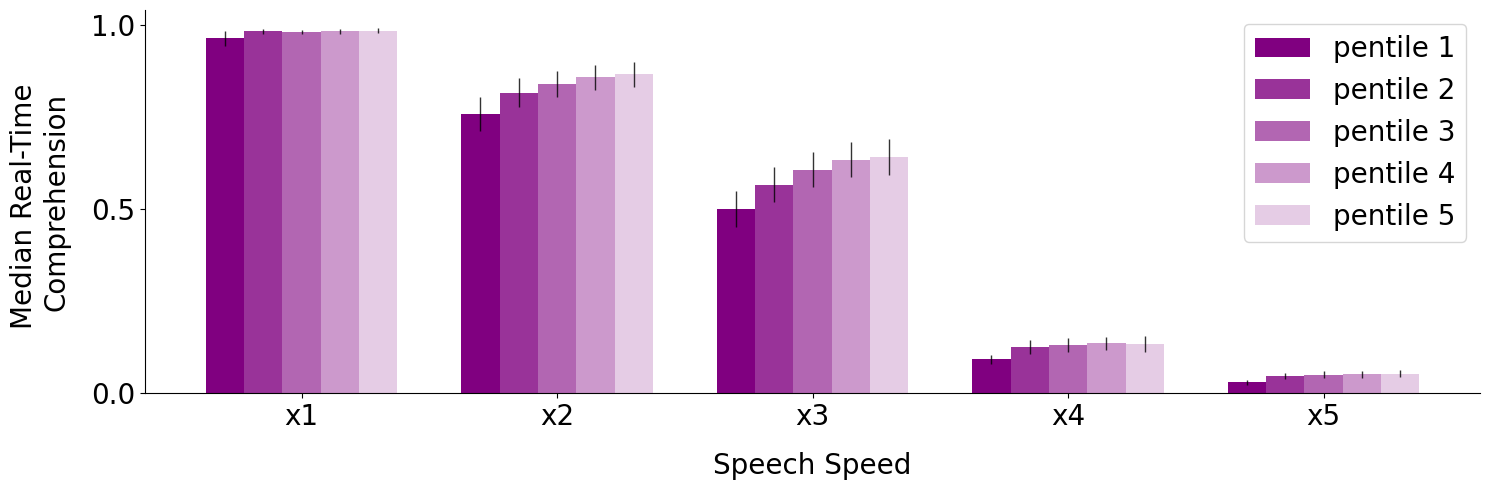

In [13]:
# plot the bins

# Prepare the data for plotting
speech_rates = sorted(long_df['speech_rate'].unique())
bins = sorted(long_df['bin'].unique())

# Create dictionaries to hold bar heights and errors for each bin
bar_heights = {bin_num: [] for bin_num in bins}
error_bars = {bin_num: [] for bin_num in bins}

# Fill in the bar heights and calculate standard error for each speech rate and bin
for bin_num in bins:
    for speech_rate in speech_rates:
        bin_data = long_df[(long_df['speech_rate'] == speech_rate) & (long_df['bin'] == bin_num)]['median_real_time']
        if len(bin_data) > 0:
            bar_heights[bin_num].append(bin_data.mean())
            error_bars[bin_num].append(bin_data.std() / np.sqrt(len(bin_data)))  # Standard error
        else:
            bar_heights[bin_num].append(0)  # If no data, append 0
            error_bars[bin_num].append(0)  # No error for empty data

# Bar width and x locations
bar_width = 0.15
x = np.arange(len(speech_rates))

# Generate shades of purple for each bin
colors = [(0.5, 0, 0.5, 1 - 0.2 * i) for i in range(len(bins))]  # RGBA: purple with decreasing alpha

# Plot with adjusted height
fig, ax = plt.subplots(figsize=(15, 5))  # Adjusted height to 6

for i, bin_num in enumerate(bins):
    ax.bar(
        x + i * bar_width, 
        bar_heights[bin_num], 
        yerr=error_bars[bin_num], 
        width=bar_width, 
        label=f'pentile {bin_num}', 
        color=colors[i], 
        error_kw={'capsize': 0, 'elinewidth': 1, 'alpha': 0.8}  # Error bar customization
    )

# Customize plot
ax.set_xlabel('Speech Speed', fontsize=20, labelpad=15)
ax.set_ylabel('Median Real-Time \nComprehension', fontsize=20, labelpad=15)
ax.set_title('', fontsize=25, pad=20)
ax.set_xticks(x + bar_width * (len(bins) - 1) / 2)
ax.set_xticklabels([f'x{sr}' for sr in speech_rates], fontsize=20)
ax.legend(title='', fontsize=20)

# Set y-axis ticks
ax.set_yticks([0, 0.5, 1])
ax.tick_params(axis='both', labelsize=20)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add gridlines and show the plot
plt.tight_layout()
plt.show()

# Does comprehension increse towards the end of segments
Check the effects of speech rate and bin on real_time comp scores- ANOVA

In [14]:
# Fit the ANOVA model with interaction
model = ols('median_real_time ~ C(speech_rate) * C(bin)', data=long_df).fit()

# Perform the ANOVA
anova_results = anova_lm(model, typ=2)
print(anova_results)

                          sum_sq     df            F         PR(>F)
C(speech_rate)         76.187714    4.0  1003.879542  2.625894e-244
C(bin)                  0.325095    4.0     4.283578   2.028016e-03
C(speech_rate):C(bin)   0.183608   16.0     0.604821   8.810162e-01
Residual                9.960993  525.0          NaN            NaN
